In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.7 MB/s eta 0:00:00


In [ ]:
import math
from transformers import GPT2Tokenizer, TFGPT2Model
import tensorflow as tf
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
     

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')    

Mounted at /content/gdrive


In [ ]:
print("Tensorflow version " + tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 

print("REPLICAS: ", strategy.num_replicas_in_sync)

Tensorflow version 2.12.0
Running on TPU  grpc://10.30.249.106:8470


REPLICAS:  8


In [ ]:
df = pd.read_pickle('/content/gdrive/MyDrive/cleantrain.pkl')

In [ ]:
#df = df.sample(120000,random_state=30)

In [ ]:
X = df['clean_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [ ]:
X_train

1663533                typical conservative coward behaviour
715392                                                 clown
1641941                      std stupid trumpean derangement
1093099    irt john berry i agree that most coverage if t...
934300                              no lisa raitt will be in
                                 ...                        
613538     monster under your bed have your mommy leave t...
476696     wow a racial inquisition at the forefront of c...
358508     i have enjoyed reading your writing and will s...
713727     what a stoopid comment typical chumpster comme...
708842     it going to be a bit difficult to come to term...
Name: clean_text, Length: 216501, dtype: object

In [ ]:
MAX_LENGTH = math.ceil((X_train.apply(lambda x: len(str(x).split())).mean()))+2
MAX_LENGTH

52

In [ ]:
PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "<|endoftext|>"

# this will download and initialize the pre trained tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2",
    pad_token=PAD_TOKEN,
    eos_token=EOS_TOKEN,
    max_length=MAX_LENGTH,
    is_split_into_words=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
X_train = [str(ex) + EOS_TOKEN for ex in X_train]
X_test = [str(ex) + EOS_TOKEN for ex in X_test]

In [ ]:
X_train_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_train]
X_test_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)['input_ids'] for x in X_test]

X_train_in = tf.squeeze(tf.convert_to_tensor(X_train_), axis=1)
X_test_in = tf.squeeze(tf.convert_to_tensor(X_test_), axis=1)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
X_train_in[0]

<tf.Tensor: shape=(52,), dtype=int32, numpy=
array([28004,   605,  5940, 26769,  9172, 50256, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257,
       50257, 50257, 50257, 50257, 50257, 50257, 50257], dtype=int32)>

In [ ]:
X_train_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_train]
X_test_mask_ = [tokenizer(str(x), return_tensors='tf', max_length=MAX_LENGTH, truncation=True, pad_to_max_length=True, add_special_tokens=True)["attention_mask"] for x in X_test]

X_train_mask = tf.squeeze(tf.convert_to_tensor(X_train_mask_), axis=1)
X_test_mask = tf.squeeze(tf.convert_to_tensor(X_test_mask_), axis=1)

In [ ]:
pickle_train_inp_path='/content/gdrive/MyDrive/GPT2_inp.pkl'
pickle_train_mask_path='/content/gdrive/MyDrive/GPT2_mask.pkl'
pickle_test_inp_path='/content/gdrive/MyDrive/GPT2_test_inp.pkl'
pickle_test_mask_path='/content/gdrive/MyDrive/GPT2_test_mask.pkl'

In [ ]:
pickle.dump(X_train_in, open(pickle_train_inp_path, 'wb'))
pickle.dump(X_train_mask, open(pickle_train_mask_path, 'wb'))
pickle.dump(X_test_in, open(pickle_test_inp_path, 'wb'))
pickle.dump(X_test_mask, open(pickle_test_mask_path, 'wb'))

In [ ]:
print('Loading the saved pickle files..')

X_train_in=pickle.load(open(pickle_train_inp_path, 'rb'))
X_train_mask=pickle.load(open(pickle_test_inp_path, 'rb'))
X_test_in=pickle.load(open(pickle_train_inp_path, 'rb'))
X_test_mask=pickle.load(open(pickle_test_mask_path, 'rb'))



Loading the saved pickle files..


In [ ]:
model = TFGPT2Model.from_pretrained("gpt2", use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id)
model.training = True

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [ ]:
with strategy.scope():
  model = TFGPT2Model.from_pretrained("gpt2", use_cache=False,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id)
  model.training = True
  model.resize_token_embeddings(len(tokenizer))
  for layer in model.layers:
    layer.trainable = False
  model.summary()
  input = tf.keras.layers.Input(shape=(None,), dtype='int32')
  mask = tf.keras.layers.Input(shape=(None,), dtype='int32')
  x = model(input, attention_mask=mask)
  #x = x.last_hidden_state[:, -1]
  x = tf.reduce_mean(x.last_hidden_state, axis=1)
  x = tf.keras.layers.Dense(4, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
  x = tf.keras.layers.Dropout(0.3)(x)
  output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
  clf = tf.keras.Model([input, mask], output)
  clf.summary()
  base_learning_rate = 0.0005
  optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
  loss=tf.keras.losses.BinaryCrossentropy()


  clf.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


Model: "tfgpt2_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124440576 
 r)                                                              
                                                                 
Total params: 163,038,720
Trainable params: 38,598,144
Non-trainable params: 124,440,576
_________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []               

In [ ]:
model.resize_token_embeddings(len(tokenizer))

In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
model.summary()

Model: "tfgpt2_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 124440576 
 r)                                                              
                                                                 
Total params: 163,038,720
Trainable params: 38,598,144
Non-trainable params: 124,440,576
_________________________________________________________________


In [ ]:
input = tf.keras.layers.Input(shape=(None,), dtype='int32')
mask = tf.keras.layers.Input(shape=(None,), dtype='int32')
x = model(input, attention_mask=mask)
x = x.last_hidden_state[:, -1]
x = tf.reduce_mean(x.last_hidden_state, axis=1)
x = tf.keras.layers.Dense(8, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
output = tf.keras.layers.Dense(1, activation='softmax')(x)

In [ ]:
clf = tf.keras.Model([input, mask], output)

In [ ]:
clf.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 tfgpt2_model_2 (TFGPT2Model)   TFBaseModelOutputWi  124440576   ['input_5[0][0]',                
                                thPastAndCrossAtten               'input_6[0][0]']                
                                tions(last_hidden_s                                               
                                tate=(None, None, 7                                         

In [ ]:
base_learning_rate = 0.0005
optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate)
loss=tf.keras.losses.BinaryCrossentropy()

clf.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(
        monitor="accuracy", verbose=1, patience=3, restore_best_weights=True)

In [ ]:
y_train_in = tf.constant(y_train, dtype=tf.int32)
y_test_in = tf.constant(y_test, dtype=tf.int32)

In [ ]:
#tf.config.experimental_run_functions_eagerly(True)

In [ ]:
y_train_in

<tf.Tensor: shape=(216501,), dtype=int32, numpy=array([1, 1, 1, ..., 0, 1, 1], dtype=int32)>

In [ ]:
history = clf.fit([X_train_in, X_train_mask], y_train_in, epochs=20, batch_size=32, validation_split=0.2, callbacks=callbacks)

Epoch 1/20
5413/5413 [==============================] - 280s 46ms/step - loss: 0.5437 - accuracy: 0.7278 - val_loss: 0.3977 - val_accuracy: 0.8340
Epoch 2/20
5413/5413 [==============================] - 226s 42ms/step - loss: 0.4115 - accuracy: 0.8289 - val_loss: 0.3870 - val_accuracy: 0.8325
Epoch 3/20
5413/5413 [==============================] - 228s 42ms/step - loss: 0.3699 - accuracy: 0.8502 - val_loss: 0.4043 - val_accuracy: 0.8331
Epoch 4/20
5413/5413 [==============================] - 228s 42ms/step - loss: 0.3331 - accuracy: 0.8680 - val_loss: 0.4404 - val_accuracy: 0.8253
Epoch 5/20
5413/5413 [==============================] - 232s 43ms/step - loss: 0.2963 - accuracy: 0.8864 - val_loss: 0.5048 - val_accuracy: 0.8198
Epoch 6/20
5413/5413 [==============================] - 230s 42ms/step - loss: 0.2626 - accuracy: 0.9034 - val_loss: 0.5621 - val_accuracy: 0.8167
Epoch 7/20
5413/5413 [==============================] - 231s 43ms/step - loss: 0.2296 - accuracy: 0.9181 - val_loss: 0

KeyboardInterrupt: ignored

In [ ]:
clf.evaluate([X_test_in, X_test_mask], y_test_in)

938/938 [==============================] - 22s 22ms/step - loss: 0.6230 - accuracy: 0.8045


[0.6230040192604065, 0.8045333623886108]

In [ ]:
clf.training = False
y_pred = clf.predict([X_test_in, X_test_mask])

938/938 [==============================] - 25s 22ms/step


In [ ]:
y_pred_out = tf.math.argmax(y_pred, axis=-1)
y_pred_out

<tf.Tensor: shape=(30000,), dtype=int64, numpy=array([0, 0, 0, ..., 0, 0, 0])>

In [ ]:
print(classification_report(y_test_in, y_pred_out))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     14974
           1       0.00      0.00      0.00     15026

    accuracy                           0.50     30000
   macro avg       0.25      0.50      0.33     30000
weighted avg       0.25      0.50      0.33     30000



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<ipython-input-32-1f93f750d707>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


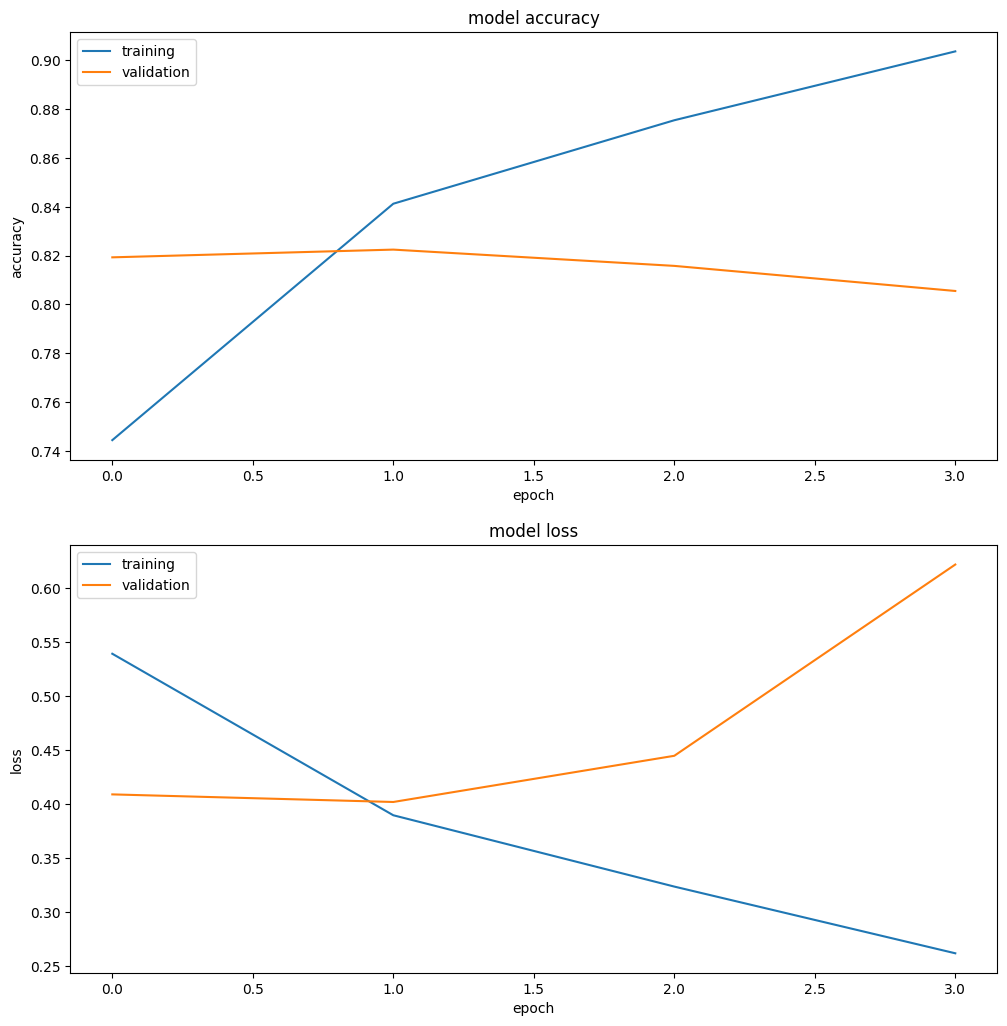

In [ ]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

plt.subplots(figsize=(10,10))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)